# Atividade 3 de CT-236 2020 

## Instalação

pip install --user igraph

pip install --user numpy

## Imports

In [28]:
import random

import numpy as np
import scipy as sp
import scipy.linalg

import igraph as ig

import matplotlib.pyplot as plt

## Funções Auxiliares

In [29]:
def community_limits(communities):
    begin_end = []
    start = 0
    end = 0
    for size in communities:
        end += size
        begin_end.append((start, end))
        start = end 
    return begin_end


def gn_builder(communities, zin, zout):
    """
    Gerador de redes Girvan-Newman
    """
    total_size = np.sum(communities)
    vertices = range(total_size)
    g = ig.Graph(total_size, directed=False)

    begin_end = community_limits(communities)

    sizes = np.array(communities)
    zin_norm = 2
    total_norm = np.sum(sizes / (total_size - sizes))
    zout_norms = [1 + total_norm - (sizes[i]/(total_size - sizes[i])) \
                    for i in range(len(sizes))]

    for idx in range(len(communities)):
        inside = range(begin_end[idx][0], begin_end[idx][1])
        for vertex in inside:
            # adding edges within community
            eligibles = [target for target in inside if target != vertex]
            chosen = np.random.choice(eligibles, zin)
            pairs = map(lambda target: (vertex, target), chosen)
            pairs = filter(lambda pair: np.random.rand() < 1/zin_norm, pairs)
            g.add_edges(pairs)

            # adding edges to outside community
            eligibles = [target for target in vertices if target not in inside]
            chosen = np.random.choice(eligibles, zout)
            pairs = map(lambda target: (vertex, target), chosen)
            pairs = filter(lambda pair: np.random.rand() < 1/zout_norms[idx], pairs)
            g.add_edges(pairs)

    adjacency = np.array(g.get_adjacency().data)
    new_adj = np.zeros_like(adjacency)
    new_adj[adjacency[:,:] != 0] = 1    # solve multiple edges bewtween i and j 
    return ig.Graph.Adjacency(new_adj.tolist(), mode=ig.ADJ_UNDIRECTED)

def er_builder(n, z):
    return ig.Graph.Erdos_Renyi(n, m=n*z)

def generator(i, communities, zin, zout):
    idx = 0
    for _ in range(i):
        g = gn_builder(communities, zin, zout)
        yield g, idx
        idx += 1

## Exemplos de redes geradas

In [30]:
communities = [32, 32, 32, 32]
zin = 14
zout = 2

color = ['red', 'green', 'blue', 'yellow']

for g, i in generator(10, communities, zin, zout):
    file_name = './images/examples/gn_i{}.png'.format(i)
    layout = g.layout()
    g.vs["color"] = [color[idx//32] for idx in g.vs.indices]
    ig.plot(g, target=file_name, layout=layout)

for i in range(10):
    file_name = './images/examples/er_i{}.png'.format(i)
    g = er_builder(np.sum(communities), (zin + zout) // 2)
    layout = g.layout()
    g.vs["color"] = [color[idx//32] for idx in g.vs.indices]
    ig.plot(g, target=file_name, layout=layout)

Degree Distribution: 
N = 64, mean +- sd: 13.0000 +- 2.6607
[ 7,  8): * (1)
[ 8,  9): ** (2)
[ 9, 10): ** (2)
[10, 11): ***** (5)
[11, 12): ******** (8)
[12, 13): ******** (8)
[13, 14): ********** (10)
[14, 15): *************** (15)
[15, 16): ***** (5)
[16, 17): ** (2)
[17, 18): *** (3)
[18, 19): * (1)
[19, 20): * (1)
[20, 21):  (0)
[21, 22):  (0)
[22, 23): * (1)

Dendrogram: 


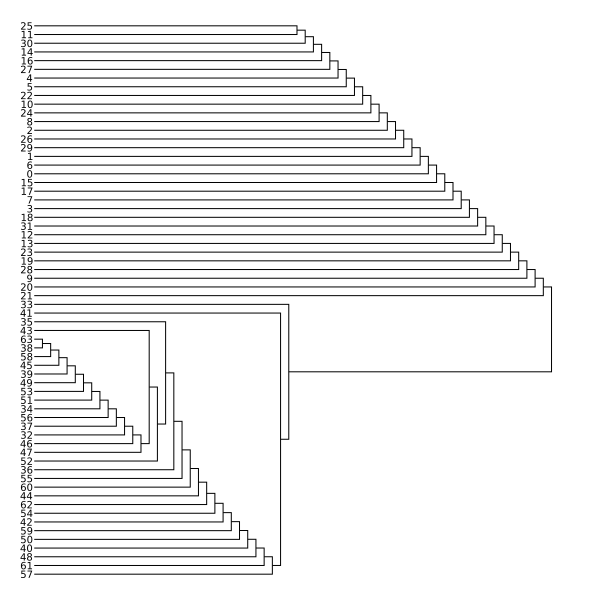

In [31]:
file_name = './images/examples/dendrogram.png'.format(i)

communities = [32, 32]
g = gn_builder(communities, 14, 2)

print('Degree Distribution: ')
print(g.degree_distribution())
print()

print('Dendrogram: ')
dendrogram = g.community_fastgreedy()
ig.plot(dendrogram, target=file_name)

## Análise Espectral

In [32]:
def spectral_analysis(g, normalized=False):
    laplacian = np.matrix(g.laplacian())
    degree = sp.linalg.fractional_matrix_power(np.diag(g.degree()),-0.5)
    normal = degree * laplacian * degree
    if not normalized:
        normal = laplacian
    eig_val, eig_vec = np.linalg.eig(normal)

    idx = eig_val.argsort()
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:,idx]
    return eig_val, eig_vec

In [33]:
sizes = [64, 64]
zin = 14
zout = 2

gn = gn_builder(sizes, zin, zout)
gn_eig_val, gn_eig_vec = spectral_analysis(gn)

er = er_builder(np.sum(sizes), (zin + zout)//2)
er_eig_val, er_eig_vec = spectral_analysis(er)


### Análise: Autovalores de Fiedler

In [34]:
print('Fiedler Eigenvalues: \n')
print('GN: ', gn_eig_val[1])
print('ER: ', er_eig_val[1])

Fiedler Eigenvalues: 

GN:  3.2576605879371634
ER:  6.071565557303561


### Plot: Autovalores

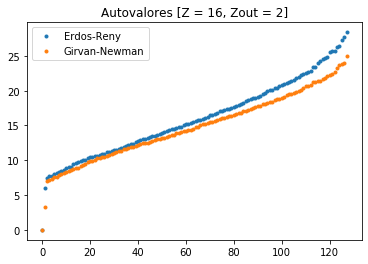

In [35]:
plt.plot(er_eig_val, '.')
plt.plot(gn_eig_val, '.')
plt.title('Autovalores [Z = 16, Zout = 2]')
plt.legend(['Erdos-Reny', 'Girvan-Newman'])
plt.savefig('./images/results/exp0/eigenvalues.png')

### Plot: Autovetor de Fiedler

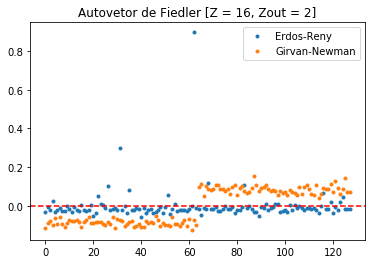

In [36]:
fiedler_er = er_eig_vec[:,1]
fiedler_gn = gn_eig_vec[:,1]

plt.plot(fiedler_er, '.')
plt.plot(fiedler_gn, '.')
plt.axhline(y=0, c='r', ls='--')
plt.title('Autovetor de Fiedler [Z = 16, Zout = 2]')
plt.legend(['Erdos-Reny', 'Girvan-Newman'])
plt.savefig('./images/results/exp0/eigenvector.png')

## Primeiro Experimento

In [37]:
NUM_SAMPLES = 10

sizes = [64, 64]
limits = community_limits(sizes)
z = 16

accuracies = []
eig_values = []
eig_vectors = []
zins = []
zouts = []

for diff in range(2, z//2):
    zin = (z//2) + diff
    zout = (z//2) - diff
    wrongs = []
    for g, i in generator(NUM_SAMPLES, sizes, zin, zout):
        file_prefix = './images/results/exp1/zin{}_zout{}_i{}'.format(zin, zout, i)
        communities = g.community_leading_eigenvector(clusters=len(sizes))
        ig.plot(communities, target=file_prefix+'_img.png')

        eig_val, eig_vec = spectral_analysis(g)
        eig_values.append(eig_val)
        eig_vectors.append(eig_vec)

        membership = communities.membership
        num_wrong = 0
        for idx in range(len(membership)):
            comm = membership[idx]
            if not(limits[comm][0] <= idx and idx < limits[comm][1]):
                num_wrong += 1
        wrongs.append(num_wrong)
    accuracies.append(1 - (np.mean(wrongs) / len(membership)))
    zins.append(zin)
    zouts.append(zout)
    print('Error for zin={:2d} zout={:2d}: {:g}'.format(zin, zout, np.mean(wrongs) / len(membership)))

total_size = np.sum(sizes)
eig_values = np.reshape(eig_values, (len(zouts), NUM_SAMPLES, total_size))
eig_vectors = np.reshape(eig_vectors, (len(zouts), NUM_SAMPLES, total_size, total_size))

Error for zin=10 zout= 6: 0.501563
Error for zin=11 zout= 5: 0.145313
Error for zin=12 zout= 4: 0.0289063
Error for zin=13 zout= 3: 0.00546875
Error for zin=14 zout= 2: 0.00078125
Error for zin=15 zout= 1: 0


### Análise: Autovalores de Fiedler

In [38]:
print('Fiedler Eigenvalues: \n')
for i in range(len(zouts)):
    fiedler = eig_values[i,:,1]
    print('Zout =', zouts[i], '=>', fiedler)
    print('Zout =', zouts[i], '=> Mean =', np.mean(fiedler))
    print()

Fiedler Eigenvalues: 

Zout = 6 => [7.05361969 6.18479131 6.98563158 6.52412999 6.01221755 4.45642803
 6.17011492 4.54192955 5.3693676  6.18481565]
Zout = 6 => Mean = 5.948304586389069

Zout = 5 => [6.38866387 6.87957973 6.53438891 4.54139096 5.40797118 6.44197515
 5.4114844  6.80839439 6.44944244 5.69892716]
Zout = 5 => Mean = 6.0562218186066445

Zout = 4 => [5.90365645 5.37154809 6.31676147 5.85710611 5.66508215 6.17391421
 6.63796778 6.22709011 4.49244341 5.76502262]
Zout = 4 => Mean = 5.841059241438597

Zout = 3 => [5.32092323 5.02773475 5.03575445 4.83174808 4.66692771 4.85583171
 4.70679719 4.82580834 5.53222858 4.73101118]
Zout = 3 => Mean = 4.9534765223215045

Zout = 2 => [3.32157109 3.13465365 3.43270418 3.44490965 3.56876647 3.17724232
 3.04512079 3.4593432  3.45777018 3.77337711]
Zout = 2 => Mean = 3.3815458633740207

Zout = 1 => [1.87983039 1.85300255 1.99898299 1.92800455 1.93772802 1.85413815
 1.68718233 1.94984153 1.61438298 1.68761003]
Zout = 1 => Mean = 1.8390703528372

### Plot: Autovalores

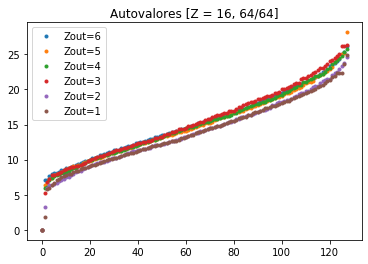

In [39]:
legends = ['Zout={}'.format(zout) for zout in zouts]

for i in range(len(zouts)):    
    plt.plot(eig_values[i, 0, :], '.')

plt.title('Autovalores [Z = 16, 64/64]')
plt.legend(legends)
plt.savefig('./images/results/exp1/eigenvalues.png')

### Plot: Autovetor de Fiedler

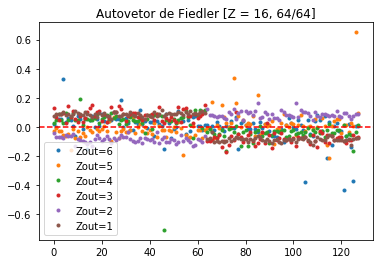

In [40]:
legends = ['Zout={}'.format(zout) for zout in zouts]

for i in range(len(zouts)):  
    fiedler = eig_vectors[i,0,:,1]  
    plt.plot(fiedler, '.')

plt.axhline(y=0, c='r', ls='--')
plt.title('Autovetor de Fiedler [Z = 16, 64/64]')
plt.legend(legends)
plt.savefig('./images/results/exp1/eigenvectors.png')

### Plot: Acurácia na detecção de comunidade

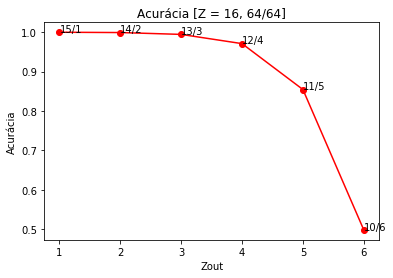

In [41]:
plt.plot(zouts, accuracies, 'ro-')

xys = list(zip(zouts, accuracies))
for i in range(len(zouts)):
    plt.annotate('%d/%d' % (zins[i], zouts[i]), xys[i], textcoords='data')

plt.xlabel('Zout')
plt.ylabel('Acurácia')
plt.title('Acurácia [Z = 16, 64/64]')
plt.savefig('./images/results/exp1/accuracy.png')

## Segundo Experimento

In [42]:
NUM_SAMPLES = 10

num_vertices = 128
zout = 1
zin = 15

accuracies = []
eig_values = []
eig_vectors = []
nums = []

for num in range(2, 6, 1):
    size = num_vertices // num
    sizes = np.ones((num,), dtype=int) * size
    sizes[-1] += num_vertices - num * size 
    limits = community_limits(sizes)

    wrongs = []
    for g, i in generator(NUM_SAMPLES, sizes, zin, zout):
        file_prefix = './images/results/exp2/zin{}_zout{}_i{}'.format(zin, zout, i)
        communities = g.community_leading_eigenvector(clusters=num)
        ig.plot(communities, target=file_prefix+'_img.png')

        eig_val, eig_vec = spectral_analysis(g)
        eig_values.append(eig_val)
        eig_vectors.append(eig_vec)

        membership = communities.membership
        num_wrong = 0
        for idx in range(len(membership)):
            comm = membership[idx]
            if not(limits[comm][0] <= idx and idx < limits[comm][1]):
                num_wrong += 1
        wrongs.append(num_wrong)

    accuracies.append(1 - (np.mean(wrongs) / len(membership)))
    nums.append(num)


total_size = np.sum(sizes)
eig_values = np.reshape(eig_values, (len(nums), NUM_SAMPLES, total_size))
eig_vectors = np.reshape(eig_vectors, (len(nums), NUM_SAMPLES, total_size, total_size))

### Análise: Autovalores de Fiedler

In [43]:
print('Fiedler Eigenvalues: \n')
for i in range(len(nums)):
    fiedler = eig_values[i,:,1]
    print('#comunidades =', nums[i], '=>', fiedler)
    print('#comunidades =', nums[i], '=> Mean =', np.mean(fiedler))
    print()

Fiedler Eigenvalues: 

#comunidades = 2 => [1.7894826  2.0147272  1.63115812 1.7262741  1.93892871 1.54786757
 1.82403503 1.6710053  1.80238325 1.73513896]
#comunidades = 2 => Mean = 1.7681000861146725

#comunidades = 3 => [1.43695016 1.28904987 1.19212965 1.35152302 1.38887497 1.50655847
 1.16579925 1.33584765 1.19372028 1.1618559 ]
#comunidades = 3 => Mean = 1.302230921549926

#comunidades = 4 => [0.94508312 0.87993781 0.91339796 1.04335751 1.05588753 1.04108168
 0.97923902 0.91507438 0.97579877 1.1526781 ]
#comunidades = 4 => Mean = 0.9901535873763063

#comunidades = 5 => [0.90706836 0.6506149  0.87799157 0.9085655  0.65265518 0.99454556
 0.7776447  0.97303649 0.90814596 0.86188488]
#comunidades = 5 => Mean = 0.8512153095673483



### Plot: Autovalores

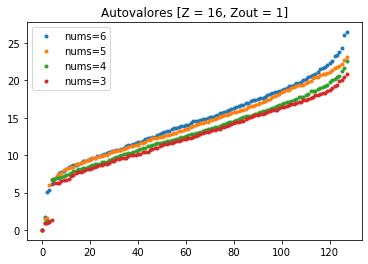

In [44]:
legends = ['nums={}'.format(zout) for zout in zouts]

for i in range(len(nums)):    
    plt.plot(eig_values[i, 0, :], '.')

plt.title('Autovalores [Z = 16, Zout = 1]')
plt.legend(legends)
plt.savefig('./images/results/exp2/eigenvalues.png')

### Plot: Autovetor de Fiedler

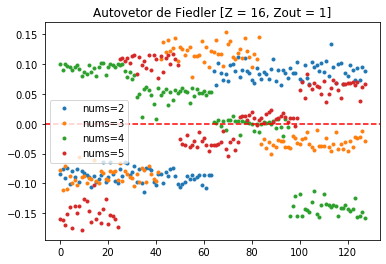

In [45]:
legends = ['nums={}'.format(num) for num in nums]

for i in range(len(nums)):  
    fiedler = eig_vectors[i,0,:,1]  
    plt.plot(fiedler, '.')

plt.axhline(y=0, c='r', ls='--')
plt.title('Autovetor de Fiedler [Z = 16, Zout = 1]')
plt.legend(legends)
plt.savefig('./images/results/exp2/eigenvectors.png')

### Plot: Acurácia na detecção de comunidade

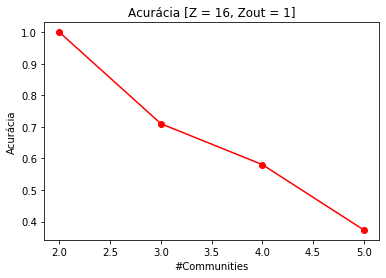

In [46]:
plt.plot(nums, accuracies, 'ro-')
plt.xlabel('#Communities')
plt.ylabel('Acurácia')
plt.title('Acurácia [Z = 16, Zout = 1]')
plt.savefig('./images/results/exp2/accuracy.png')

## Terceiro Experimento

In [47]:
NUM_SAMPLES = 10

num_vertices = 128
z = 16
zouts = 2
zin = z - zout
proportions = np.arange(2.0, 5.5, 1)

accuracies = []
eig_values = []
eig_vectors = []
ratios = []

for ratio in proportions:
    denom = int(1 + ratio)
    sizes = [num_vertices // denom, num_vertices - num_vertices // denom]
    limits = community_limits(sizes)

    wrongs = []
    for g, i in generator(NUM_SAMPLES, sizes, zin, zout):
        file_prefix = './images/results/exp3/zin{}_zout{}_i{}'.format(zin, zout, i)
        communities = g.community_leading_eigenvector(clusters=len(sizes))
        ig.plot(communities, target=file_prefix+'_img.png')

        eig_val, eig_vec = spectral_analysis(g)
        eig_values.append(eig_val)
        eig_vectors.append(eig_vec)

        membership = communities.membership
        num_wrong = 0
        for idx in range(len(membership)):
            comm = membership[idx]
            if not(limits[comm][0] <= idx and idx < limits[comm][1]):
                num_wrong += 1
        wrongs.append(num_wrong)

    accuracies.append(1 - (np.mean(wrongs) / len(membership)))
    ratios.append(ratio)

total_size = num_vertices
eig_values = np.reshape(eig_values, (len(ratios), NUM_SAMPLES, total_size))
eig_vectors = np.reshape(eig_vectors, (len(ratios), NUM_SAMPLES, total_size, total_size))

### Análise: Autovalores de Fiedler

In [48]:
print('Fiedler Eigenvalues: \n')
for i in range(len(ratios)):
    fiedler = eig_values[i,:,1]
    print('Ratio =', ratios[i], '=>', fiedler)
    print('Ratio =', ratios[i], '=> Mean =', np.mean(fiedler))
    print()

Fiedler Eigenvalues: 

Ratio = 2.0 => [2.54774749 2.41022227 2.30350119 2.07418779 2.34896058 2.4978663
 2.12714821 2.1863899  2.063761   2.29849002]
Ratio = 2.0 => Mean = 2.2858274743619402

Ratio = 3.0 => [3.09747975 2.55975652 3.14243255 2.92043973 2.93760529 2.95677462
 2.71365608 2.97347677 3.03177465 2.84273365]
Ratio = 3.0 => Mean = 2.91761296139486

Ratio = 4.0 => [3.49275891 3.90302565 3.32242794 3.71089104 3.65404575 3.67258955
 4.04626157 3.94236292 3.63883384 3.5437843 ]
Ratio = 4.0 => Mean = 3.6926981472619067

Ratio = 5.0 => [4.77821304 4.90608962 5.14960418 4.43029946 4.2873334  4.64510943
 4.72630881 4.56531829 4.46603026 4.47593736]
Ratio = 5.0 => Mean = 4.643024386068598



### Plot: Autovalores

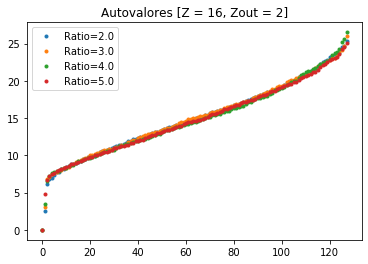

In [49]:
legends = ['Ratio={}'.format(ratio) for ratio in ratios]

for i in range(len(ratios)):    
    plt.plot(eig_values[i, 0, :], '.')

plt.title('Autovalores [Z = 16, Zout = 2]')
plt.legend(legends)
plt.savefig('./images/results/exp3/eigenvalues.png')

### Plot: Autovetor de Fiedler

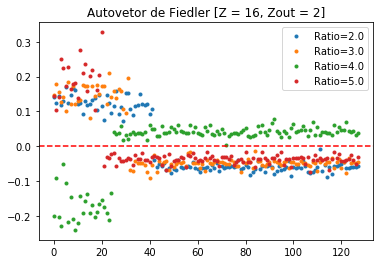

In [50]:
legends = ['Ratio={}'.format(ratio) for ratio in ratios]

for i in range(len(ratios)):  
    fiedler = eig_vectors[i,0,:,1]  
    plt.plot(fiedler, '.')

plt.axhline(y=0, c='r', ls='--')
plt.title('Autovetor de Fiedler [Z = 16, Zout = 2]')
plt.legend(legends)
plt.savefig('./images/results/exp3/eigenvectors.png')

### Plot: Acurácia na detecção de comunidade

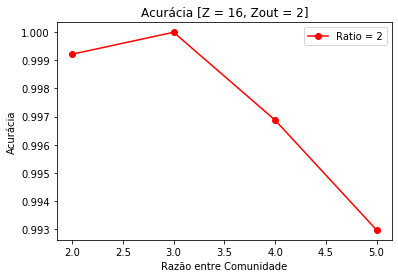

In [51]:
plt.plot(ratios, accuracies, 'ro-')
plt.xlabel('Razão entre Comunidade')
plt.ylabel('Acurácia')
plt.title('Acurácia [Z = 16, Zout = 2]')
plt.legend(['Ratio = 2', 'Ratio = 3', 'Ratio = 4'])
plt.savefig('./images/results/exp3/accuracy.png')

## Quarto Experimento

### Importando redes

In [52]:
gs = []

g = ig.Graph.Read_Edgelist('./datasets/lastfm_asia_edges.edges', directed=False)
g.simplify()
print(g.summary())
gs.append(g)

g = ig.Graph.Read_Edgelist('./datasets/facebook.edges', directed=False)
g.simplify()
print(g.summary())
gs.append(g)

IGRAPH U--- 7624 27806 -- 
IGRAPH U--- 4039 84243 -- 


### Processando

In [53]:
import time

for i in range(len(gs)):
    g = gs[i]
    print('\nNETWORK: {}\n'.format(i))


    # Fiedler
    print('Fiedler started')
    start = time.time()
    fiedler = g.community_leading_eigenvector()
    print('Time: ', time.time() - start)
    print('Modularity: ', fiedler.modularity)

    fiedler_g = fiedler.cluster_graph()
    ig.plot(fiedler_g, target='./images/results/bench/i{}_fiedler.png'.format(i))
    print('Fiedler finished\n')

    # Greedy
    print('Greedy started')
    start = time.time()
    greedy = g.community_fastgreedy().as_clustering()
    print('Time: ', time.time() - start)
    print('Modularity: ', greedy.modularity)

    greedy_g = fiedler.cluster_graph()
    ig.plot(greedy_g, target='./images/results/bench/i{}_greedy.png'.format(i))
    print('Greedy finished\n')



NETWORK: 0

Fiedler started
Time:  3.1480305194854736
Modularity:  0.7450386461444217
Fiedler finished

Greedy started
Time:  0.3270604610443115
Modularity:  0.7966054632778499
Greedy finished


NETWORK: 1

Fiedler started
Time:  1.8230457305908203
Modularity:  0.8241127441608489
Fiedler finished

Greedy started
Time:  0.15883183479309082
Modularity:  0.7855324746101787
Greedy finished

